In [1]:
# Sets up import path, if you're running from the source distrib
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../..'))

In [2]:
import traceback

# VisTrails API example

This notebook showcases the new API. Inlined are some comments and explanations.

In [3]:
import vistrails as vt

The new API is exposed under the top-level `vistrails` package. The moment you use one of the API functions, like `load_vistrail()`, it will create an application and load the same configuration that the VisTrails application uses (although it will automatically enable packages the moment you need them).

In [4]:
vt.ipython_mode(True)

This explicitely requests IPythonMode to be enabled on output modules, so that pipeline executions will put results on the notebook (similarly to `%matplotlib inline` for matplotlib plots).

## `Vistrail`s and `Pipeline`s

You can get a `Vistrail` through `load_vistrail()`.

In [5]:
vistrail = vt.load_vistrail('simplemath.vt')

A `Vistrail` is a whole version tree, where each version is a different pipeline. From it we can get `Pipeline`s, but it is also stateful (i.e. has a current version); this is useful for editing (creating new versions from the current one). It also provides the interface that `Pipeline` has, implicitely acting on the `current_pipeline`.

If GraphViz is available, `Vistrail` and `Pipeline` will be rendered in the IPython notebook.

In [6]:
vistrail

<Vistrail: simplemath.vt, version -1, not changed>

In [7]:
vistrail.select_latest_version()

In [8]:
vistrail

<Vistrail: simplemath.vt, version 37, not changed>

In [9]:
vistrail.get_pipeline(2)

<Pipeline: 1 modules, 0 connections>

# Packages

Only `basic_modules` (and `abstractions`?) are loaded on initialization, so that using the API stays fast. A package might be auto-enabled when it is requested, which is efficient and convenient.

Note that `load_package()` only accepts package identifiers.

In [10]:
tabledata = vt.load_package('org.vistrails.vistrails.tabledata')
tabledata

<Package: org.vistrails.vistrails.tabledata, 23 modules>

You can get `Module`s from the package using the dot or bracket syntax. These modules are "dangling" modules, not yet instanciated in a specific pipeline/vistrail.

These will be useful once editing pipelines is added to the API.

In [11]:
tabledata.convert

<Namespace convert of package org.vistrails.vistrails.tabledata>

In [12]:
from vistrails.core.modules.module_registry import MissingModule
try:
    tabledata['convert']  # can't get namespaces this way, use a dot
except MissingModule:
    pass
else:
    assert False

In [13]:
tabledata.BuildTable, tabledata['BuildTable']

(<Module class 'BuildTable' from org.vistrails.vistrails.tabledata>,
 <Module class 'BuildTable' from org.vistrails.vistrails.tabledata>)

In [14]:
tabledata.read.CSVFile, tabledata['read|CSVFile']

(<Module class 'CSVFile' from org.vistrails.vistrails.tabledata>,
 <Module class 'CSVFile' from org.vistrails.vistrails.tabledata>)

# Execution

In addition to executing a `Pipeline` or `Vistrail`, you can easily pass values in on InputPort modules (to use subworkflows as Python functions) and get results out (either on OutputPort modules or any port of any module).

Execution returns a `Results` object from which you can get all of this. In addition, output modules (such as matplotlib's MplFigureOutput) will output to the IPython notebook if possible.

## Gets output

In [15]:
outputs = vt.load_vistrail('outputs.vt')
outputs.select_version(1)
outputs

<Vistrail: outputs.vt, version 1, not changed>

In [16]:
# Errors
try:
    result = outputs.execute()
except vt.ExecutionErrors:
    traceback.print_exc()
else:
    assert False

Traceback (most recent call last):
  File "<ipython-input-16-979bf6416e43>", line 3, in <module>
    result = outputs.execute()
  File "/home/remram/Documents/programming/dat/vistrails/examples/api/../../vistrails/core/api.py", line 259, in execute
    return self.current_pipeline.execute(*args, **kwargs)
  File "/home/remram/Documents/programming/dat/vistrails/examples/api/../../vistrails/core/api.py", line 482, in execute
    raise ExecutionErrors(self, result)
ExecutionErrors: Pipeline execution failed: 1 error:
0: Missing value from port value


In [17]:
# Results
outputs.select_latest_version()
result = outputs.execute()
result

<ExecutionResult: 2 modules>

In [18]:
outputs

<Vistrail: outputs.vt, version 5, changed>

In [19]:
outputs.current_pipeline

<Pipeline: 2 modules, 1 connections; outputs: msg>

This gets the value on any output port of any module (no need to insert OutputPort or GenericOutput modules, if you know how to find the module):

In [20]:
result.module_output(0)

{'self': <vistrails.core.modules.basic_modules.String at 0x5bd7bb0>,
 'value': 'Hello, world',
 'value_as_string': 'Hello, world'}

This gets the value passed to an OutputPort module, using the OutputPort's name:

In [21]:
result.output_port('msg')

'Hello, world'

## Sets inputs

In [22]:
pipeline = vistrail.current_pipeline
pipeline

<Pipeline: 6 modules, 6 connections; inputs: in_a, in_b; outputs: out_times, out_plus>

In [23]:
in_a = pipeline.get_input('in_a')
assert (in_a == pipeline.get_module('First input')) is True
in_a

<Module 'InputPort' from org.vistrails.vistrails.basic, id 1, name "First input">

We need to provide value to this workflow, for its two InputPort modules. Input can be supplied to `execute()` in two ways:
* either by using `module_obj == value`, where module_obj is a module obtained from the pipeline, using `get_input()` or `get_module()`;
* or by using `module_name=value`, where module_name is the name set on an InputPort module

Note that, to Python, `module_obj` is a variable and must be bound to a value (of type Module), whereas module_name is a keyword-parameter name.

In [24]:
result = pipeline.execute(in_a == 2, in_b=4)

In [25]:
result.output_port('out_times'), result.output_port('out_plus')

(8.0, 6.0)

## Other example

In [26]:
im = vt.load_vistrail('imagemagick.vt')

In [27]:
im.select_version('read')
im

<Vistrail: imagemagick.vt, version 6 (tag read), not changed>

Note that if you print a File value, IPython will try to render it.

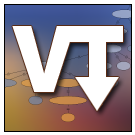

In [28]:
im.execute().output_port('result')

In [29]:
im.select_version('blur')
im

<Vistrail: imagemagick.vt, version 14 (tag blur), changed>

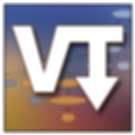

In [30]:
im.execute().output_port('result')

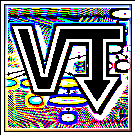

In [31]:
im.select_version('edges')
im.execute().output_port('result')

## Output mode

In [32]:
mpl = vt.load_vistrail('../matplotlib/pie_ex1.vt')
mpl.select_latest_version()

This workflow uses MplFigureOutput, which outputs to the IPython notebook if available (and since the spreadsheet is not running).

  UserWarning)



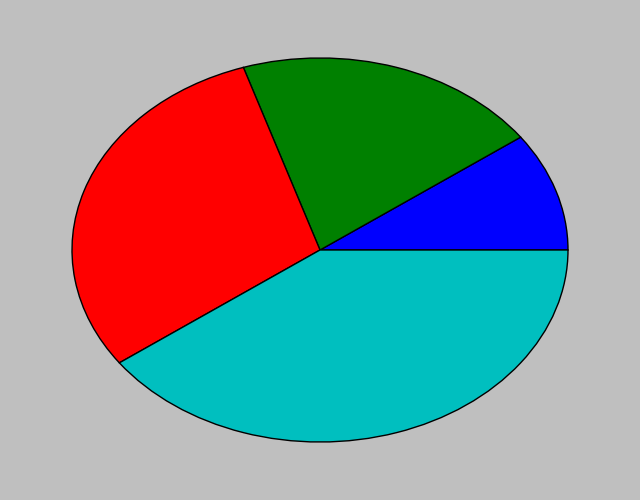

<ExecutionResult: 3 modules>

In [33]:
mpl.execute()

In [34]:
richtext = vt.load_vistrail('out_html.xml')
richtext.select_latest_version()

This one uses RichTextOutput:

In [35]:
richtext.execute()

<ExecutionResult: 2 modules>

In [36]:
tbl = vt.load_vistrail('table.xml')
tbl.select_latest_version()

TableOutput:

In [37]:
tbl.execute()

a,b
1,4
2,5
3,6


<ExecutionResult: 2 modules>

In [38]:
render = vt.load_vistrail('brain_output.xml')
render.select_latest_version()

And vtkRendererOutput:

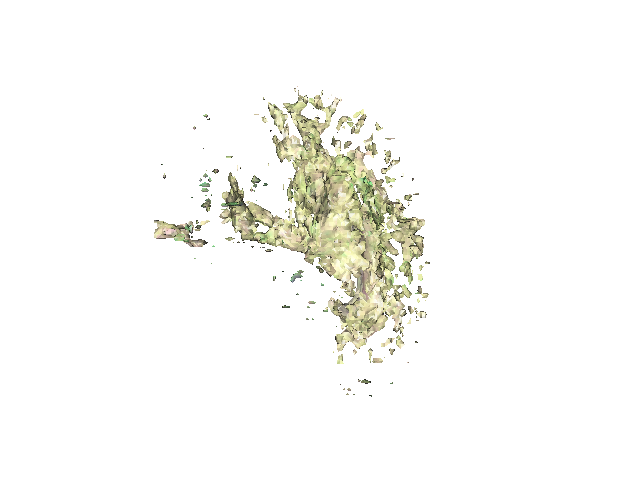

<ExecutionResult: 16 modules>

In [39]:
render.execute()

# Pipeline manipulation

The API wrapper doesn't currently provide easier methods to manipulate pipelines. This is mainly because these operations need all of the VisTrails concepts anyway.

You can however call the controller methods on vistrail.controller directly, using modules obtained through `load_package()`.

In [39]:
import urllib2

In [40]:
basic = vt.load_package('org.vistrails.vistrails.basic')
pythoncalc = vt.load_package('org.vistrails.vistrails.pythoncalc')

In [41]:
new_vistrail = vt.Vistrail()

# Simple Integer constant
data = new_vistrail.controller.add_module_from_descriptor(basic.Integer.descriptor)
new_vistrail.controller.update_function(data, 'value', ['8'])

# PythonSource module
pythonblock = new_vistrail.controller.add_module_from_descriptor(basic.PythonSource.descriptor)
new_vistrail.controller.update_ports(pythonblock.id,
                                      [],
                                      [('output', 'computed_number', 'org.vistrails.vistrails.basic:Float')])
new_vistrail.controller.update_function(pythonblock, 'source', [urllib2.quote(r"""\
number = 211856436.75
while number > 10.0:
    number /= 7.0
computed_number = number
""")])

# Python calc that multiply inputs
multiply = new_vistrail.controller.add_module_from_descriptor(pythoncalc.PythonCalc.descriptor)
new_vistrail.controller.update_function(multiply, 'op', ['*'])

# StandardOutput, here it will print to the notebook
output = new_vistrail.controller.add_module_from_descriptor(basic.StandardOutput.descriptor)

# Add connections
new_vistrail.controller.add_connection(data.id, 'value', multiply.id, 'value1')
new_vistrail.controller.add_connection(pythonblock.id, 'computed_number', multiply.id, 'value2')
new_vistrail.controller.add_connection(multiply.id, 'value', output.id, 'value')

In [42]:
new_vistrail.current_version

11

In [43]:
new_vistrail.current_pipeline

<Pipeline: 4 modules, 3 connections>

In [44]:
new_vistrail.execute()

42.0


<ExecutionResult: 4 modules>